# Problem : Sudoku Solver

In this problem, we will build a sudoku solver, first detect it and then solve the sudoku. Let's first instantiate the environment.

In [1]:
using Pkg
Pkg.instantiate()

Let's load packages that we will be using!

In [2]:
using Images
using Plots
using FileIO
using Flux
using BSON

using TestImages
using CoordinateTransformations
using StaticArrays
using ImageBinarization
using Sudoku

`sudoku/utilities.jl` contains all major function required for this sudoku solving task. LeNet5_e20.bson are model weight which is used char recognition.

In [3]:
include("sudoku/utilities.jl");


Let's load the testimage which we wants to use for problem solving.

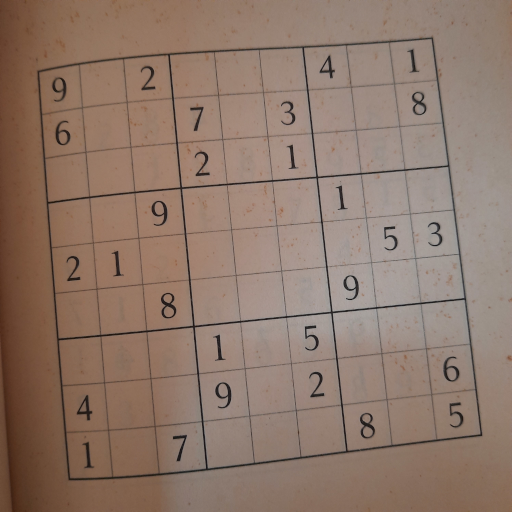

In [4]:
image_raw = testimage("sudoku")
image = copy(image_raw)

[ Info: CartesianIndex{2}[CartesianIndex(71, 38), CartesianIndex(481, 69), CartesianIndex(437, 482), CartesianIndex(38, 434)]


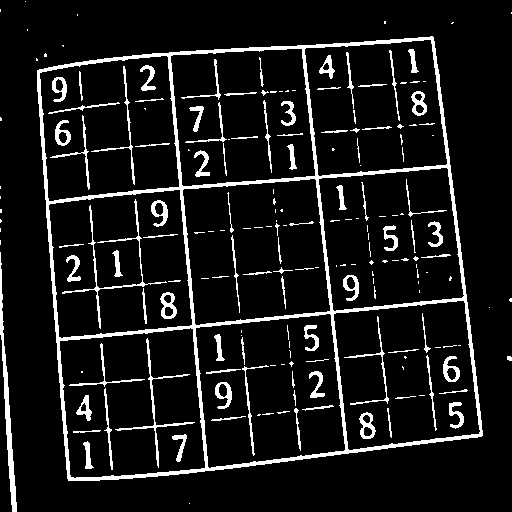

In [5]:
blackwhite, quad = detect_grid(
    image; 
    max_size=1024, 
    blur_window_size=5, σ=1.1, 
    threshold_window_size=15, threshold_percentage=7)
@info quad
blackwhite

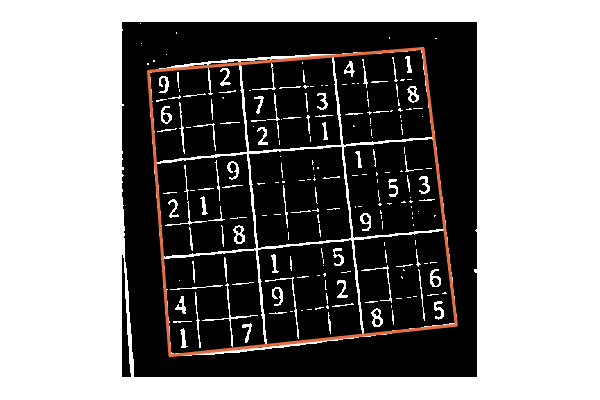

In [6]:
canvas = plot(blackwhite)

x = [point[2] for point in vcat(quad, quad[1])]
y = [point[1] for point in vcat(quad, quad[1])]
plot!(canvas, x, y, linewidth=3, label="", ticks=:none, border=:none)

Using `four_point_transform`, we can transform the tilted image to straightened image using homography matrix.

  1.656371 seconds (2.02 M allocations: 113.691 MiB, 9.81% gc time, 76.64% compilation time)


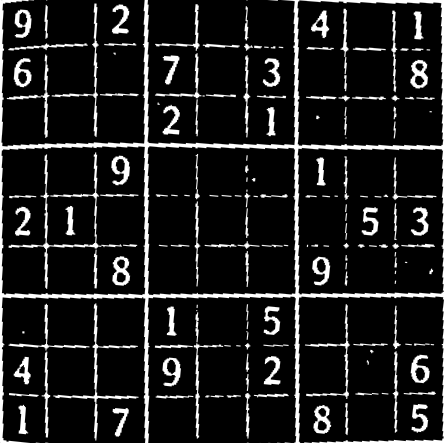

In [7]:
@time warped, invM = four_point_transform(blackwhite, quad)
warped

Load the model for char recognition and compile it before usage.

In [8]:
BSON.@load "sudoku/LeNet5_e20.bson" model
model(zeros(Float32, (28, 28, 1, 1))) # compile
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

This will read the image, digits innit in Tiled fashion and we have various parameters that we can use to control how it works.

In [9]:
grid1, centres, probs = read_digits(warped, model, offset_ratio=0.1, radius_ratio=0.25, detection_threshold=0.1);

Drawing on the image before we solve it!

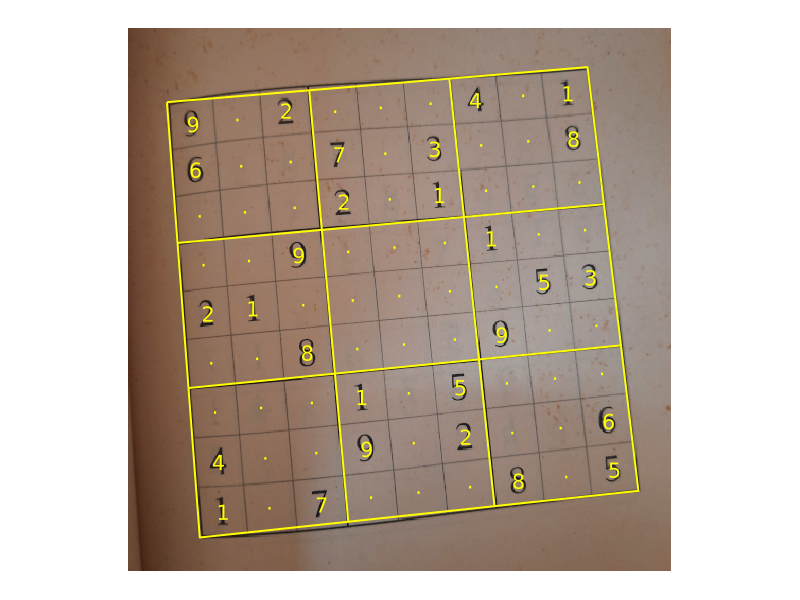

In [10]:
pred_threshold = 0.90
image_out = imresize(image, size(blackwhite));
canvas = plot(image_out, ticks=nothing, border=:none, size=(800, 600));

for line in construct_grid(size(warped, 1), size(warped, 2), nblocks=3)
    line_unwarped = map(point -> perspective_transform(invM)(point), line)
    xs = [point[2] for point in line_unwarped]
    ys = [point[1] for point in line_unwarped]
    plot!(canvas, xs, ys, label="", linewidth=2, color=:yellow)
end

centres_aligned = align_centres(centres, probs .> pred_threshold)
for i in 1:9
    for j in 1:9
        centre = centres_aligned[i, j]
        centre_unwarped = perspective_transform(invM)(centre)
        label =  (probs[i, j] > pred_threshold) ? string(grid1[i, j]) : "·"
        annotate!(canvas, centre_unwarped[2], centre_unwarped[1], label, :yellow)
    end
end
canvas

In [11]:
filepath, ext = splitext("input.png")
filename = splitpath(filepath)[end]
savefig(canvas, joinpath("sudoku/", filename * "_read" * ".png"))

"C:\\Users\\lenono\\Documents\\StudyCode\\JuliaCon23_ImageProcessingWorkshop\\sudoku\\input_read.png"

Solving the sudoku with Sudoku.jl, Thanks to Ed Scheinerman for Sudoku.jl

In [12]:
grid_orig = copy(grid1)
pred_threshold = 0.90
grid_orig[probs .< pred_threshold] .= 0
grid_orig
grid_solved = sudoku(grid_orig)

[ Info: Solver Cbc verbose is set to false


Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -LogLevel 0 -solve -quit (default strategy 1)


9×9 Matrix{Int64}:
 9  7  2  6  5  8  4  3  1
 6  4  1  7  9  3  5  2  8
 8  5  3  2  4  1  6  7  9
 5  6  9  3  2  7  1  8  4
 2  1  4  8  6  9  7  5  3
 7  3  8  5  1  4  9  6  2
 3  9  6  1  8  5  2  4  7
 4  8  5  9  7  2  3  1  6
 1  2  7  4  3  6  8  9  5

Plotting the output as a result!

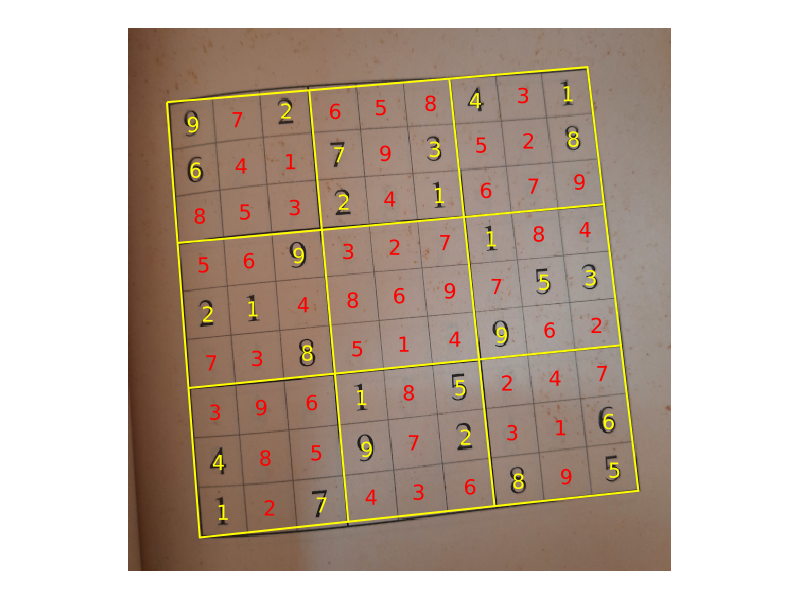

In [13]:
image_out = imresize(image, size(blackwhite));
canvas = plot(image_out, ticks=nothing, border=:none, size=(800, 600));

for line in construct_grid(size(warped, 1), size(warped, 2))
    line_unwarped = map(point -> perspective_transform(invM)(point), line)
    xs = [point[2] for point in line_unwarped]
    ys = [point[1] for point in line_unwarped]
    plot!(xs, ys, label="", linewidth=2, color=:yellow)
end

centres_aligned = align_centres(centres, grid_orig .> 0)
for i in 1:9
    for j in 1:9
        centre = centres_aligned[i, j]
        centre_unwarped = perspective_transform(invM)(centre)
        color = (grid_orig[i, j] > 0) ? :yellow : :red
        annotate!(canvas, centre_unwarped[2], centre_unwarped[1], string(grid_solved[i, j]), color)
    end
end
canvas

In [14]:
filepath, ext = splitext("output.png")
filename = splitpath(filepath)[end]
savefig(canvas, joinpath("sudoku", filename * "_solved" * ".png"))

"C:\\Users\\lenono\\Documents\\StudyCode\\JuliaCon23_ImageProcessingWorkshop\\sudoku\\output_solved.png"

## References and Credits:
- We use code present in utilities introduced in these blog posts by Lior Sionai: https://liorsinai.github.io/coding/2021/08/10/sudoku-reader-part1-intro.html, Go check out his blog posts! and Thanks lior!